<a href="https://colab.research.google.com/github/dguo98/VToonify/blob/style_transfer/Arbitrary_Style_Transfer_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stylize Your Images In 5 Minutes

Demo developed by [Sayak Paul](https://twitter.com/RisingSayak).

Neural style transfer is one of the most interesting applications of deep learning. We've created a demo to help you recreate your images in the style of famous artists.

![](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/table.png)

The image and code id adapted from [this tutorial](https://www.tensorflow.org/lite/models/style_transfer/overview). 

## To start the demo click the play button to the left of each cell, one by one.

You need to run the following cells in order to get stylized images.

The easiest way to do that is to click on the cell and press Shift + Enter or press the play button. Each cell takes between 10-30 seconds to execute.

In [1]:
#@title 1. Setup 🧰
#@markdown Just run this cell as is. ***Don't modify the code block.*** The setup should not take more than two minutes. 
!pip uninstall -q -y tensorflow 
!pip install -q tf-nightly

from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
 
!pip install wandb -qq
import wandb
wandb.login(anonymous='allow')
clear_output()
content_image = None # This needs to be in global scope

print('You are all set!')

You are all set!


When prompted for `Proceed (y/n)?` please choose "y". 

In [2]:
#@title 2. Choose a style image from the options below 🎆

STYLE_IMAGE_NAME = 'IMAGE_3' #@param ['IMAGE_1', 'IMAGE_2', 'IMAGE_3', 'IMAGE_4', 'IMAGE_5']

corresponding_url = {
    'IMAGE_1': 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
    'IMAGE_2': 'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg',
    'IMAGE_3': 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1024px-Tsunami_by_hokusai_19th_century.jpg',
    'IMAGE_4': 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg/800px-Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
    'IMAGE_5': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/757px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'
}

style_image_path = tf.keras.utils.get_file(STYLE_IMAGE_NAME + ".jpg", corresponding_url[STYLE_IMAGE_NAME])

import os
os.chdir('/')
input_dir = "stylize_frames/data/front_frames"
output_dir = "stylize_frames/results/front_frames"
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
style_image_path = "stylize_frames/data/catoon9.png"


print("Style image downloaded!")

289526/289526 [==============================] - 0s 0us/step
Style image downloaded!


<center><img src = 'https://i.ibb.co/Tmnwnbc/Untitled-Diagram.png'></img></center>

In [7]:
#@title 3. Upload an image you want to stylize 🖼
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import numpy as np
import io

content_image = Image.open("stylize_frames/data/front_frames/0001.jpg")

"""
clear_output()

def button_click(change):
  global content_image
  print('\n')
  img = Image.open(io.BytesIO(uploader.data[-1]))
  content_image = img
  img = img.convert('RGB')
  img.thumbnail((256, 256))
  img.save('thumbnail.jpg')
  image = Image.open('thumbnail.jpg')
  display(image)
  
uploader = widgets.FileUpload()
show_button = widgets.Button(description='Show image')
show_button.on_click(button_click)

widgets.VBox([widgets.Label('Upload a content image (must be an RGB or RGBA image). High-res images might take more time to be processed.'), uploader, show_button])
"""

"\nclear_output()\n\ndef button_click(change):\n  global content_image\n  print('\n')\n  img = Image.open(io.BytesIO(uploader.data[-1]))\n  content_image = img\n  img = img.convert('RGB')\n  img.thumbnail((256, 256))\n  img.save('thumbnail.jpg')\n  image = Image.open('thumbnail.jpg')\n  display(image)\n  \nuploader = widgets.FileUpload()\nshow_button = widgets.Button(description='Show image')\nshow_button.on_click(button_click)\n\nwidgets.VBox([widgets.Label('Upload a content image (must be an RGB or RGBA image). High-res images might take more time to be processed.'), uploader, show_button])\n"

You can upload as many images as you would want to but we will only pick the last uploaded one. 

In [38]:
#@title [Optional] You can also use your Webcam! 📸
#@markdown Just execute this cell and click anywhere in the streaming feed.

#@markdown Courtesy: https://ricardodeazambuja.com/
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
    global content_image
    display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    f = io.BytesIO(binary)
    content_image = Image.open(f)
    print('\nImage captured! 🤳')

take_photo()

KeyboardInterrupt: ignored

In [8]:
#@title 4. Preprocess the images 👾
#@markdown ***Don't modify this code block.***
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to load an image from a file, and add a batch dimension.
def load_content_img(image_pixels):
    if image_pixels.shape[-1] == 4:
        image_pixels = Image.fromarray(image_pixels)
        img = image_pixels.convert('RGB')
        img = np.array(img)
        img = tf.convert_to_tensor(img)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = img[tf.newaxis, :]
        return img
    elif image_pixels.shape[-1] == 3:
        img = tf.convert_to_tensor(image_pixels)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = img[tf.newaxis, :]
        return img
    elif image_pixels.shape[-1] == 1:
        raise Error('Grayscale images not supported! Please try with RGB or RGBA images.')
    print('Exception not thrown')

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image



Preprocessing the style and the content images...
Style image shape: (1, 256, 256, 3)
Content image shape: (1, 384, 384, 3)


In [9]:
#@title 5. Download the style transfer networks from TF Hub 💻
#@markdown ***Don't modify this code block.***
#@markdown 

# Download the style bottleneck and transfer networks
print('Downloading the model files...')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/sayakpaul/lite-model/arbitrary-image-stylization-inceptionv3/int8/predict/1?lite-format=tflite')
style_transform_path = style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/sayakpaul/lite-model/arbitrary-image-stylization-inceptionv3/int8/transfer/1?lite-format=tflite')

print('Model files downloaded...')

2169438/2169438 [==============================] - 2s 1us/step
Model files downloaded...


ValueError: ignored

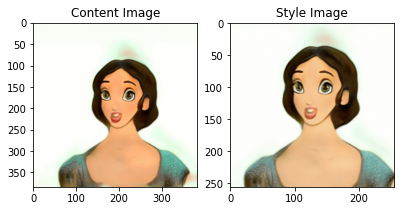

In [11]:

# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck


# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  for index in range(len(input_details)):
    if input_details[index]["name"]=='Conv/BiasAdd':
      interpreter.set_tensor(input_details[index]["index"], style_bottleneck)
    elif input_details[index]["name"]=='content_image':
      interpreter.set_tensor(input_details[index]["index"], preprocessed_content_image)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image



Preprocessing the style and the content images...
Style image shape: (1, 256, 256, 3)
Content image shape: (1, 384, 384, 3)
Calculating style bottleneck...
Style Bottleneck Shape: (1, 1, 1, 100)
Stylizing image. It should not take more than three minutes...
stylized_image


<Figure size 432x288 with 0 Axes>

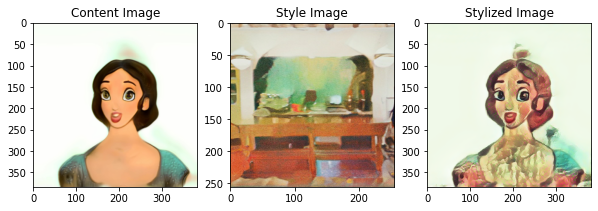

In [25]:
#@title 6. Stylize image 🥁

content_blending_ratio = 0.8 #@param {type:"slider", min:0, max:1, step:0.1}
#@markdown You're encouraged to play with the different values of `content_blending_ratio`.

plt.clf()
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(preprocessed_style_image, 'Style Image')


style_image_path = "stylize_frames/data/background.jpg"

content_image = Image.open("stylize_frames/data/front_frames/0001.jpg")

# Convert the content image from Bytes to NumPy array.
content_image = np.array(content_image)

# Load the input images.
content_image = load_content_img(content_image)
style_image = load_img(style_image_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Preprocessing the style and the content images...')
print('Style image shape:', preprocessed_style_image.shape)
print('Content image shape:', preprocessed_content_image.shape)
# Calculate style bottleneck for the preprocessed style image.
print('Calculating style bottleneck...')
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)
print('Stylizing image. It should not take more than three minutes...')

# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
)

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck_blended, preprocessed_content_image)

# Visualize the output.
plt.subplot(1, 3, 3)
imshow(stylized_image, 'Stylized Image')
print("stylized_image")

In [31]:
from glob import glob
from tqdm import tqdm 

style_image_path = "stylize_frames/data/background.jpg"
style_image = load_img(style_image_path)
preprocessed_style_image = preprocess_image(style_image, 256)
style_bottleneck = run_style_predict(preprocessed_style_image)

input_dir = "stylize_frames/data/front_frames"
content_image_paths = sorted(glob(f"{input_dir}/*.jpg"))

for content_image_path in tqdm(content_image_paths, desc="stylizing"):
  content_image = Image.open(content_image_path)

  # Convert the content image from Bytes to NumPy array.
  content_image = np.array(content_image)

  # Load the input images.
  content_image = load_content_img(content_image)
  

  # Preprocess the input images.
  preprocessed_content_image = preprocess_image(content_image, 384)


  # Calculate style bottleneck of the content image.
  style_bottleneck_content = run_style_predict(
      preprocess_image(content_image, 256)
  )

  # Blend the style bottleneck of style image and content image
  style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                            + (1 - content_blending_ratio) * style_bottleneck

  # Stylize the content image using the style bottleneck.
  stylized_image = run_style_transform(style_bottleneck_blended, preprocessed_content_image)
  #print("stylized_image.shape=", stylized_image.shape)
  save_path = content_image_path.replace("data", "results")
  Image.fromarray(np.uint8(stylized_image.reshape(384,384,3)*255)).save(save_path)
  #print("stylized_image=", stylized_image)
  #break


stylizing: 100%|██████████| 110/110 [03:33<00:00,  1.94s/it]


In [32]:
!ffmpeg -r 24 -f image2 -i stylize_frames/results/front_frames/%04d.jpg -vcodec mpeg4 -b 2M stylize_frames/results/front.mp4
!ffmpeg -i stylize_frames/results/front.mp4 -i stylize_frames/data/front_audio.m4a -c copy -map 0:v:0 -map 1:a:0 stylize_frames/results/front_audio.mp4


ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [ ]:
#@title 7. Save your results 💥
#@markdown If you experiment with the different `content_blending_ratio` values make sure you run this code block again in order to store your results online.

style_image_resized = tf.image.resize(preprocessed_style_image, (preprocessed_content_image.shape[1], preprocessed_content_image.shape[2]))
images = [preprocessed_content_image, style_image_resized, stylized_image]
captions = ["content_image", "style_image", "stylized_image"]

wandb.init(project='styletransfer', entity='wandb', anonymous='allow')
wandb.log({"Results": [wandb.Image(tf.squeeze(image, 0), caption=caption)
    for (image, caption) in zip(images, captions)]})
display(wandb.jupyter.Run())

Just click the link above that corresponds to `Run page` to see the results in a separate Browser tab. 